### this code is to implement the SmartSifter algorithm introduced by Prof. Yamanishi. 
### SmartSifter is an sequential unsupervised anomaly detection algorithm to detect out anomaly datam from sequential data. The core idea is to use incremental EM algorithm for parameter update. Innovation of the SmartSifter algorithm is to use the discounting rate to enhance the effect of current data, meanwhile suppress the effect of very old datas 
### For more information, please refer to Prof. Yamanishi's paper [Kenji Yamanishi et al, 'Online Unsupervised Outlier Detection Using Finite Mixtures with Discounting Learning Algorithms', KDD2004]
### simplifications are made here, including omitting categorial data $x_t$  

In [502]:
from scipy.stats import norm
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import scipy as sp 
%matplotlib inline
import pdb;
from six.moves import xrange
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [503]:
# normalization 
def localNorm(data):
    dataM = np.mean(data, axis = 1)
    data = data - dataM[:,np.newaxis]
    dataStd = np.std(data, axis = 1)
    data = data / dataStd[:,np.newaxis] 
    return data 

# constrast normalisation
def contrastNorm(data):
    dataM = np.mean(data, axis = 0)
    data = data - dataM[np.newaxis,:]
    dataStd = np.std(data, axis = 0)
    data = data / dataStd[np.newaxis,:] 
    return data 

## SDEM (Sequentially Discounting EM) algorithm -- not work right now

In [504]:
def SDEM (data, r, alpha, k):
    """ sequential discounting EM algorithm for GMM model parameter estimation
    Args:
        data -- raw data for detecting anomaly
        r -- discounting parameter. [0.9,1.0)
        alpha -- factor for stability, usually alpha range (1.0,2.0) 
        k -- number of mixture components in GMM 
    Returns:
        c -- prior pdf vector of each Gaussian model
        mu -- mean matrix of GMM model
        sigma -- 3D variance matrix of learned GMM model
    """

    dataNum = data.shape[0]
    dataDim = data.shape[1] 
    c = 1.0 / k * np.ones((k,1), dtype = float)
    mu = np.random.uniform(low= -3, high= 3, size= (k, dataDim))
#     muM = np.random.randn(k,dataDim)
    sigma = np.tile(np.random.rand(dataDim,dataDim),[k,1,1])
#     sigmaM = np.tile(np.eye(dataDim),[k,1,1]) 
    gamma = np.zeros((k,1), dtype= float)
    post = np.zeros((k,1), dtype= float)
    
    for i in xrange(dataNum):
        y = data[i,:][:,np.newaxis]; 
        print 'c:\n', c
        print 'mu:\n', mu
        print 'sigma: \n', sigma
        
        for j in xrange(k):
            # calculate posterior pdf of each mixture component
            post[j,0] = c[j,0] * normal_pdf(y, mu[j,:][:,np.newaxis], sigma[j,:,:])
        
        print 'post: \n', post
        for j in xrange(k):
#             pdb.set_trace()
            gamma[j,0] = (1.0- alpha*r) * post[j,0]/sum(post) + alpha*r/k 
            c[j,0] = (1.0-r)*c[j,0] + r*gamma[j,0]
            mu[j,:] = (1.0 - r)*mu[j,:] + r*gamma[j,0]*y.T
            mu[j,:] = mu[j,:]/c[j,0]
            sigma[j,:,:] = (1.0-r)*sigma[j,:,:] + r * gamma[j,0]*np.dot(y,y.T)
            sigma[j,:,:] = sigma[j,:,:]/c[j,0] - np.dot(mu[j,:][:,np.newaxis], mu[j,:][np.newaxis,:])
#             sigma[j,:,:] = sigma[j,:,:]/c[j,0] 
            
    return c, mu, sigma
            
    

##  standard EM algorithm (to check whether SDPU works correctly)

In [505]:
def GMM_EM(data, k):
    """ standard EM algorithm for estimating GMM model parameters
    Args:
        data: inputdata with each row as a sample 
        k: number of mixture components
    Returns:
        c: mixing coefficient
        mu: mean matrix of each component 
        sigma: covariance matrix of each component
    """
    # initialize pi, mu, sigma, loglikeliPre
    dataNum = data.shape[0]
    dataDim = data.shape[1] 
    c = 1.0 / k * np.ones((k,1), dtype = float)
    mu = np.random.randn(k, dataDim)
    sigma = np.tile(0.5* np.eye(dataDim),[k,1,1])
    gamma = np.zeros((dataNum, k), dtype = float)
    comp = np.zeros((dataNum, k), dtype = float)
    logLikeliPre = 0.0
    thres = 1.0e-5* dataNum 
    firstTime = 1
#     pdb.set_trace()
    while firstTime == 1 or abs(logLikeliNext - logLikeliPre) >= thres:
        if firstTime == 1:
            for d in xrange(dataNum):
                for i in xrange(k):
                    comp[d,i] = c[i,0] * normal_pdf(data[d,:][:,np.newaxis], mu[i,:][:,np.newaxis], sigma[i,:,:])

            logLikeliNext = np.sum(np.log(np.sum(comp, axis = 1))) 
            gamma = comp/np.sum(comp, axis = 1)[:, np.newaxis] 
            firstTime = 0
        else: 
            # M-step 
            logLikeliPre = logLikeliNext 
            NK = np.sum(gamma, axis = 0)[:,np.newaxis]
            c = NK/np.sum(NK)
            mu = np.dot(gamma.T, data)/NK
            for i in xrange(k):
                u = mu[i,:][np.newaxis,:]
                sigma[i,:,:] = np.dot(np.dot((data-u).T, np.diag(gamma[:,i])), data-u)/NK[i] 
                
            # E-step
            for d in xrange(dataNum):
                for i in xrange(k):
                    comp[d,i] = c[i,0] * normal_pdf(data[d,:][:,np.newaxis], mu[i,:][:,np.newaxis], sigma[i,:,:])
            
            # calculate log-likelihood
            logLikeliNext = np.sum(np.log(np.sum(comp, axis = 1))) 
            print 'loglike difference: ', abs(logLikeliNext - logLikeliPre)
            gamma = comp/np.sum(comp, axis = 1)[:, np.newaxis]
        
    return c, mu, sigma


##  SDPU (sequential discounting prototype updating)

In [506]:
def SDPU(data, K, r, sigma):
    """ sequential discounting prototype updating algorithm for learning parameters of GMM model, 
    this is the non-parametric or kernel version of the sequential discounting EM algorithm. 
    Args:
        data: raw data for anomaly detection 
        k: number of mixture components
        r: discounting rate
        sigma: hyperparameter, variance of prototype with Gaussian distribution
    Returns:
        q: mean of Guassian kernel of prototypes 
    """
    dataNum, dataDim = data.shape
    q = np.random.uniform(low= -3, high= 3, size= (K, dataDim))
    B = np.zeros((K, dataDim), dtype = float)
    C = np.zeros((K, dataDim, K, dataDim), dtype = float) # with order [k,l,j,m]
    crossKernel = np.zeros((K,dataDim), dtype = float) # cross-kernel size: [K,dataDim]
    hScore = np.zeros(dataNum, dtype = float)
    llScore = np.zeros(dataNum, dtype = float)
    for d in xrange(dataNum):
        x = data[d,:]
        llScore[d]= SDPU_Logloss(x[:,np.newaxis], K, q, sigma)
        if d%500 == 0:
            print 'data: %d / %d extracted' %(d, dataNum) 
        # calculate kernel matrix between every qi, qj combination 
        for k in xrange(K):
            qk = q[k,:][np.newaxis,:]
#             print (q-qk).shape
            expk = np.exp(-np.diag(np.dot(q-qk, (q-qk).T))/(4.0*sigma))[np.newaxis,:]
            crossKernel[k,:] = np.dot(expk, q-qk)
        # calculate B and C 
        for k in xrange(K):
            for l in xrange(dataDim):
                B[k,l] = r* (K * (x[l] - q[k,l]) * G_kernel(x, q[k,:], sigma) - crossKernel[k,l])
                for j in xrange(K):
                    for m in xrange(dataDim):
                        C[k,l,j,m] = (np.eye(dataDim)[m,l] - 
                                      (q[k,l]-q[j,l])*(q[k,m]-q[j,m])/(2.0*sigma))*G_kernel(q[k,:],q[j,:],sigma)
        B_vector = np.reshape(B, (K*dataDim,1))
        C_vector = np.reshape(C, (K*dataDim, K*dataDim)) 
        q_delta = np.linalg.solve(C_vector, B_vector)
        q_delta = q_delta.reshape((K, dataDim))
        hScore[d] = SDPU_Hellinger_score(q, q+q_delta, sigma)
#         print 'delta q: \n', np.linalg.norm(q_delta)
        q = q + q_delta
#         print 'q: \n', q
    return q, hScore, llScore
                        

In [507]:
def SDPU_Logloss(x, k, q, sigma):
    """ calculate logarithmic loss 
    Args:
        x: test data, eg. [10,1] 
        k: number of mixture component
        q: mean matrix of Gaussian eg. [3,10]
        sigma: variance eg: 2.0
    """
    kernelPdf = np.zeros(k, dtype= float)
    for i in xrange(k):
        kernelPdf[i] = normal_pdf(x, q[i,:][:,np.newaxis], sigma*np.eye(q.shape[1]))
    kp = np.mean(kernelPdf)
    return -1.0*np.log(kp)

In [508]:
def SDPU_Hellinger_score(qPre, qNext, sigma):
    """ calculate Hellinger score after obtaining new datum, 
    Hellinger score evaluates the distribution change after observing new data,
    for more information, please refer to Appendix A: approximate computation of the Hellinger score
    Args:
        qPre: mean matrix before observing new datum
        qNext: mean matrix after observing new datam
        sigma: variance of Gaussian kernels
    Returns:
        hScore: hellinger score
    """
    
    hScore = np.sum(2.0- 2.0*np.exp(np.diag(3*np.dot(qPre, qPre.T) + 
                              3*np.dot(qNext, qNext.T) + 2*np.dot(qPre, qNext.T))/(4.0*sigma)))
    return hScore

In [509]:
def G_kernel(x, c, sigma):
    """calculate gaussian kernel """
    return np.exp(-1.0*np.linalg.norm(x-c)**2/(4.0*sigma))


In [510]:
def normal_pdf(x, mu, sigma):
    m = x.shape[0]
    epsi = 1.0e-6
    expPart = np.exp(-0.5 * np.dot(np.dot((x-mu).T, np.linalg.pinv(sigma)), x-mu))
    normPart = 1.0 / ((2.0*np.pi)**(m/2.0) * np.sqrt(np.linalg.det(sigma)))
    return normPart * expPart

In [511]:
def pca(data, n_components):
    pca = PCA(n_components= n_components)
    pca.fit(data)
    w = pca.components_
    dataPCA = np.dot(data,w.T)
    return dataPCA

## 1. prepare artificial data

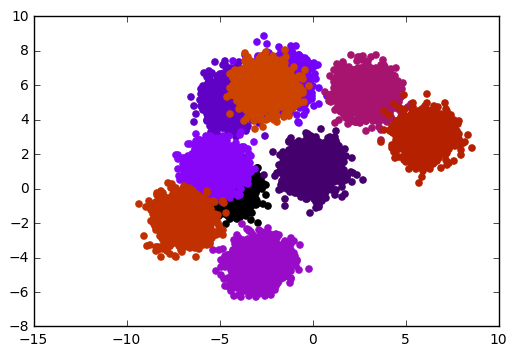

In [512]:
# generate 2D datas obeying GMM model, parameters are as below
K = 10
dataDim = 2
dataNum = 15000
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, K+5)]

# set prior, mean and variance for each Gaussian model
pi = np.random.rand(K,1); pi = pi/sum(pi)
mu = np.random.uniform(low=-7,high=7,size=(dataDim, K))
sigma = 0.5 * np.tile(np.eye(dataDim), [K,1,1])
    
# set hidden variable and generate data from it    
z = np.arange(0,K) # seed to generate hidden variable     
h = np.random.choice(z, dataNum, list(pi))  
hUniq, count = np.unique(h, return_counts=True)
data = np.empty((0,dataDim), dtype = float) 
# create normal data
for i in range(K):
    tmp = np.random.multivariate_normal(mu[:,i], sigma[i,:,:],count[i])
#     dataPCA = pca(tmp, 2)
    plt.scatter(tmp[:,0], tmp[:,1], color = colors[i])
    data = np.append(data, tmp, axis = 0)
data = data[np.random.permutation(dataNum),:] 
GTInx = np.zeros(dataNum, dtype= float)

## 2. online supervised anomaly detection

data: 0 / 15000 extracted
data: 500 / 15000 extracted
data: 1000 / 15000 extracted
data: 1500 / 15000 extracted
data: 2000 / 15000 extracted
data: 2500 / 15000 extracted
data: 3000 / 15000 extracted
data: 3500 / 15000 extracted
data: 4000 / 15000 extracted
data: 4500 / 15000 extracted
data: 5000 / 15000 extracted
data: 5500 / 15000 extracted
data: 6000 / 15000 extracted
data: 6500 / 15000 extracted
data: 7000 / 15000 extracted
data: 7500 / 15000 extracted
data: 8000 / 15000 extracted
data: 8500 / 15000 extracted
data: 9000 / 15000 extracted
data: 9500 / 15000 extracted
data: 10000 / 15000 extracted
data: 10500 / 15000 extracted
data: 11000 / 15000 extracted
data: 11500 / 15000 extracted
data: 12000 / 15000 extracted
data: 12500 / 15000 extracted
data: 13000 / 15000 extracted
data: 13500 / 15000 extracted
data: 14000 / 15000 extracted
data: 14500 / 15000 extracted


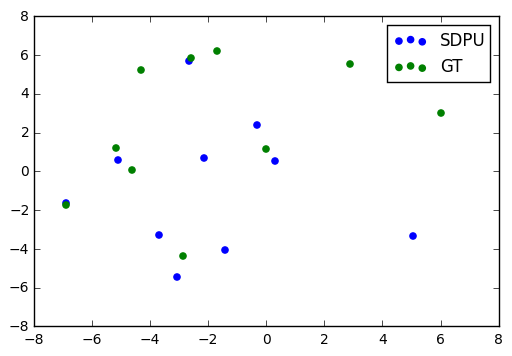

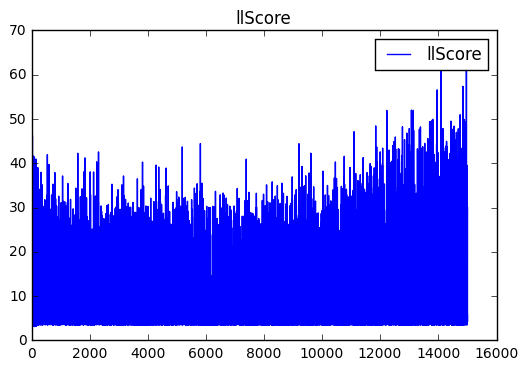

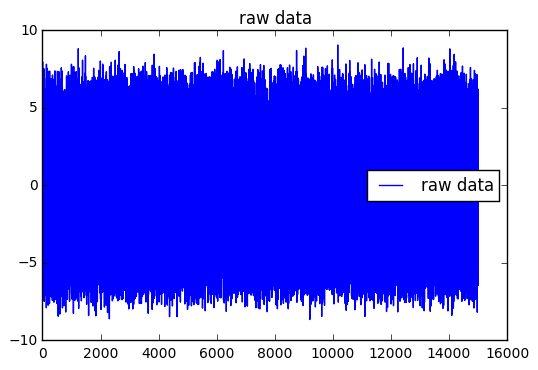

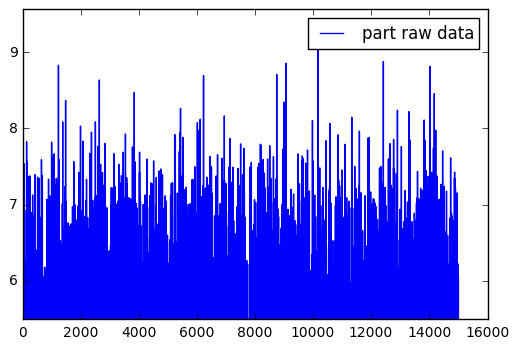

In [513]:
# test the SDEM algorithm 
alpha = 2.0
sigma = 0.5
r = 0.01
# cE, muE, sigmaE = SDEM(data, r, alpha, k)
# cE, qEM, sigmaE = GMM_EM(data, k)
qPU, hScore,llScore = SDPU(data, K, r, sigma)
# qPUPCA = pca(qPU, 2)
plt.figure()
# plt.scatter(qEM[:,0], qEM[:,1], color= 'r', label= 'EM')
plt.scatter(qPU[:,0], qPU[:,1], color= 'b', label= 'SDPU')
# muPCA = pca(mu.T, 2)
plt.scatter(mu.T[:,0], mu.T[:,1], color= 'g', label= 'GT')
plt.legend()

# # plot helligence score
# plt.figure()
# plt.plot(hScore, label= 'hScore')
# plt.legend()

plt.figure()
plt.plot(llScore, label= 'llScore')
plt.title('llScore')
plt.legend(loc= 1)

dataPCA = pca(data,1)
plt.figure()
plt.plot(dataPCA, label= 'raw data')
plt.title('raw data')
plt.legend(loc= 5)

plt.figure()
plt.plot(dataPCA, label= 'part raw data')
bottomY = 0.4* np.mean(dataPCA) + 0.6 * np.max(dataPCA)
plt.ylim(bottomY,np.max(dataPCA)+ 0.5)
plt.legend(loc = 1)

# plt.figure()
# minmax_scaler = MinMaxScaler()
# llScoreScale = minmax_scaler.fit_transform(llScore, [0,1])
# plt.scatter(xrange(dataNum + abnDataNum), llScoreScale, label= 'llScore', marker='*', color='r')
# # plt.plot(llScoreScale, label= 'llScore')
# dataPCA = pca(data,1)
# minmax_scaler = MinMaxScaler()
# dataPCAScale = minmax_scaler.fit_transform(dataPCA,[0,1])
# plt.scatter(xrange(dataNum + abnDataNum), dataPCAScale, label= 'raw data', marker='.', color='g')
# # plt.plot(dataPCAScale, label= 'raw data')
# plt.legend()

data: 0 / 15000 extracted
data: 500 / 15000 extracted
data: 1000 / 15000 extracted
data: 1500 / 15000 extracted
data: 2000 / 15000 extracted
data: 2500 / 15000 extracted
data: 3000 / 15000 extracted
data: 3500 / 15000 extracted
data: 4000 / 15000 extracted
data: 4500 / 15000 extracted
data: 5000 / 15000 extracted
data: 5500 / 15000 extracted
data: 6000 / 15000 extracted
data: 6500 / 15000 extracted
data: 7000 / 15000 extracted
data: 7500 / 15000 extracted
data: 8000 / 15000 extracted
data: 8500 / 15000 extracted
data: 9000 / 15000 extracted
data: 9500 / 15000 extracted
data: 10000 / 15000 extracted
data: 10500 / 15000 extracted
data: 11000 / 15000 extracted
data: 11500 / 15000 extracted
data: 12000 / 15000 extracted
data: 12500 / 15000 extracted
data: 13000 / 15000 extracted
data: 13500 / 15000 extracted
data: 14000 / 15000 extracted
data: 14500 / 15000 extracted


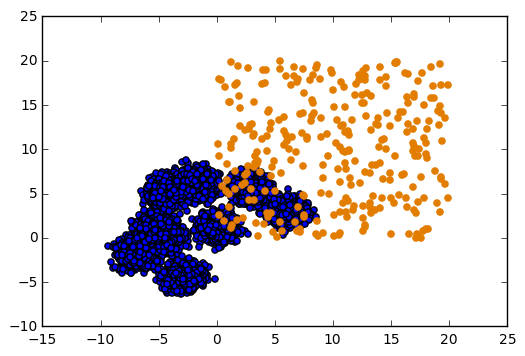

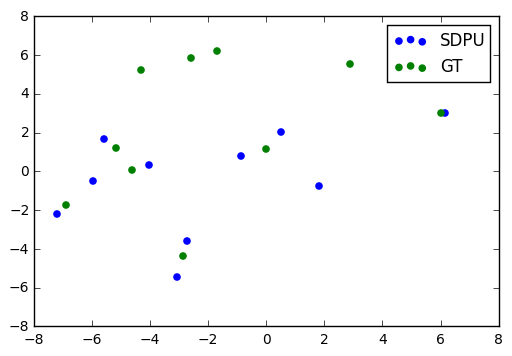

In [514]:
# create abnormal data
plt.scatter(data[:,0], data[:,1])
abnRatio = 0.02
abnDataNum = int(abnRatio*dataNum)
abnData = 20* np.random.rand(abnDataNum, dataDim)
abnInx = np.random.randint(0,dataNum,abnDataNum)
data[abnInx,:] = abnData
GTInx[abnInx] = 1.0
# abnDataPCA = pca(abnData, 2)
plt.scatter(abnData[:,0], abnData[:,1], color = colors[K+1])

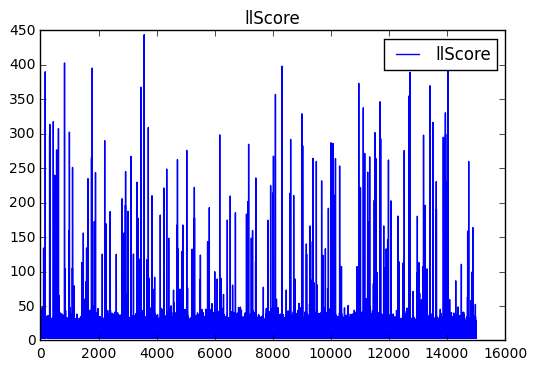

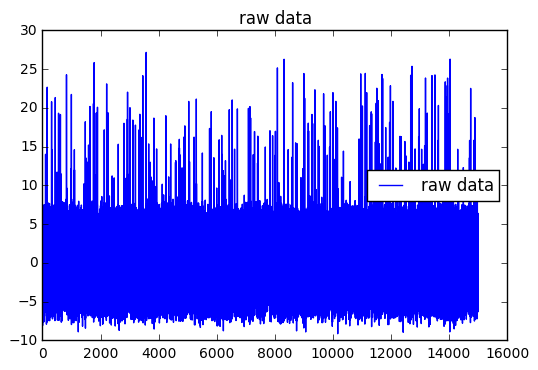

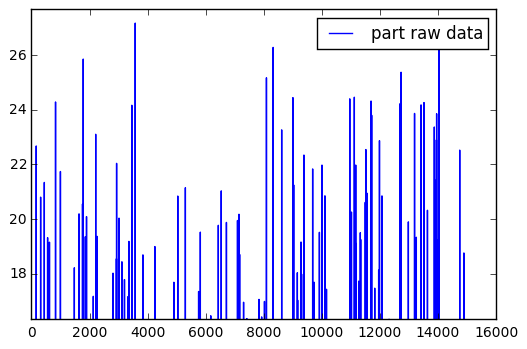

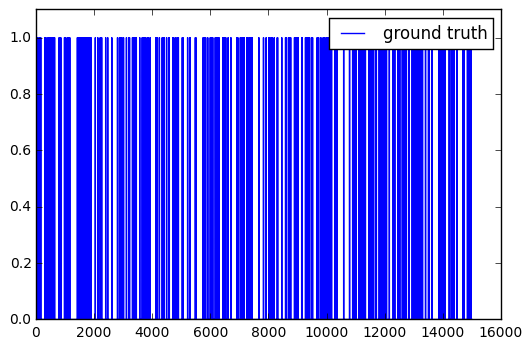

In [515]:
qPU, hScore,llScore = SDPU(data, K, r, sigma)
# qPUPCA = pca(qPU, 2)
plt.figure()
# plt.scatter(qEM[:,0], qEM[:,1], color= 'r', label= 'EM')
plt.scatter(qPU[:,0], qPU[:,1], color= 'b', label= 'SDPU')
# muPCA = pca(mu.T, 2)
plt.scatter(mu.T[:,0], mu.T[:,1], color= 'g', label= 'GT')
plt.legend()

# # plot helligence score
# plt.figure()
# plt.plot(hScore, label= 'hScore')
# plt.legend()

plt.figure()
plt.plot(llScore, label= 'llScore')
plt.title('llScore')
plt.legend(loc= 1)

dataPCA = pca(data,1)
plt.figure()
plt.plot(dataPCA, label= 'raw data')
plt.title('raw data')
plt.legend(loc= 5)

plt.figure()
plt.plot(dataPCA, label= 'part raw data')
bottomY = 0.4* np.mean(dataPCA) + 0.6 * np.max(dataPCA)
plt.ylim(bottomY,np.max(dataPCA)+ 0.5)
plt.legend(loc = 1)

plt.figure()
plt.plot(GTInx, label= 'ground truth')
plt.ylim(0,1.1)
plt.legend()